In [74]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data as mdmask
import ingest_tif_stack as ingest

In [15]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Running register_brain without mask

In [16]:
%run -i register_brain.py --config ./intern.cfg \
    --collection missing_data_registration \
    --experiment missing_half_insula_to_whole_atlas  \
    --channel Ch0 \
    --image_orientation lps \
    --outdir ./intermediate_img/

downloading experiment: missing_half_insula_to_whole_atlas, channel: Ch0...
time to download image at res 50.0 um: 1.45552802086 seconds
downloading atlas...
time to download atlas at 50 um: 0.636360883713 seconds
downsampling image...
time to downsample image: 0.973704814911 seconds
creating mask and correcting bias field in target...
time to bias correct image: 80.3444931507 seconds
image size: (135, 320, 160), image orientation: lps
atlas size: (264, 160, 228), atlas orientation: pir
normalizing atlas and target...
time taken to normalize atlas and target: 0.0316469669342 seconds
performing affine registration...
time taken for affine registration: 118.29716897 seconds
whitening images...
time to whiten atlas and target: 1123.81484485
beginning LDDMM parameter sweep

Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	94387.4, 94.4214, 0, 94293 (96.3299%), 2.750000e-03
1.	89460.8, 145.326, 0, 89315.5 (91.2449%), 3.025000e-03
2.	86

In [89]:
rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
orig_full_img = ndreg.download_image(rmt, 'ailey-dev', 'Insula_Atenolol-1_171204_new', 'Ch0', res=3)
orig_missing_img = ndreg.download_image(rmt, 'missing_data_registration', 'missing_half_insula_to_whole_atlas', 'Ch0')
atlas = atlas = ndreg.download_ara(rmt, 50)

In [122]:
sitk.WriteImage(orig_full_img, './cobalt/missing_insula/full_insula.img')

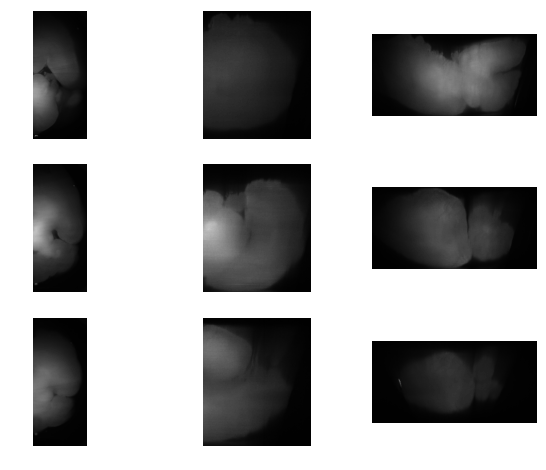

In [31]:
ndreg.imgShow(orig_missing_img, vmax=2500)

# View LDDMM results

In [33]:
lddmm_out = './intermediate_img/lddmm/out.img'
lddmm_out_img = ndreg.imgRead(lddmm_out)

In [37]:
oriented_atlas = ndreg.imgReorient(lddmm_out_img, 'pir', 'lps')
oriented_img = ndreg.imgReorient(orig_missing_img, 'lps', 'pir')

### Original image

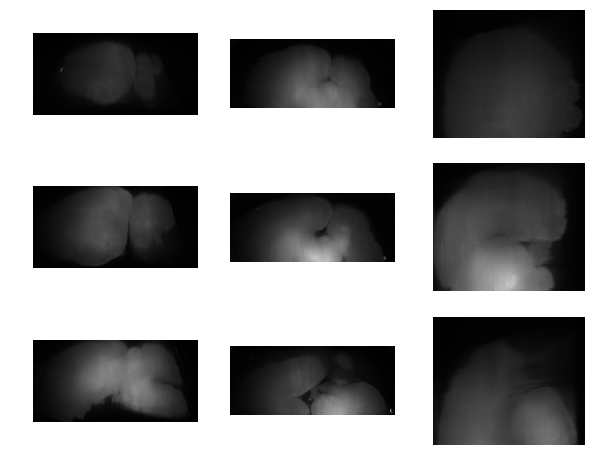

In [39]:
ndreg.imgShow(oriented_img, vmax=2500)

### LDDMM output

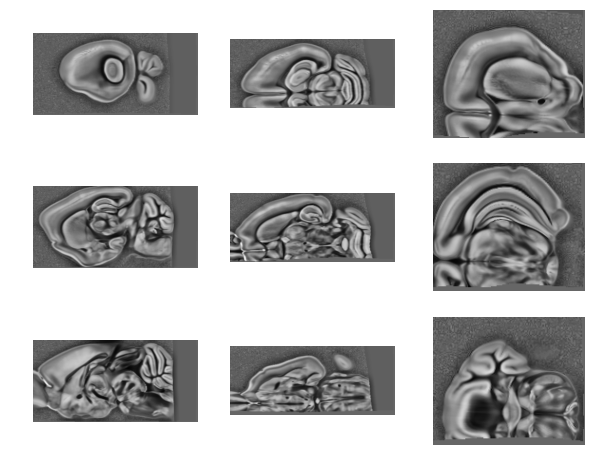

In [21]:
ndreg.imgShow(lddmm_out_img)

### Attempt to overlay

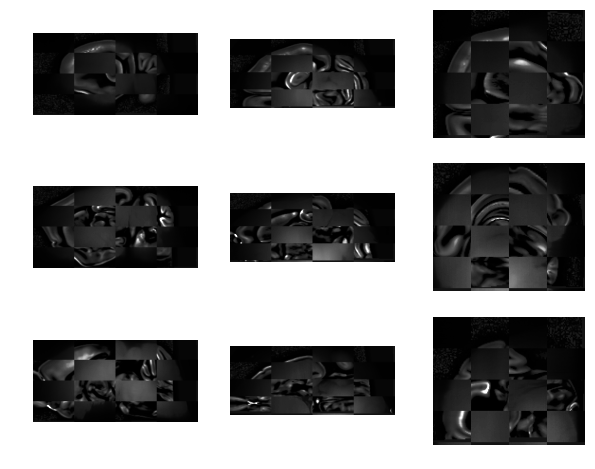

In [69]:
ndreg.imgShow(ndreg.imgChecker(sitk.Normalize(lddmm_out_img), sitk.Normalize(oriented_img)), vmax=10)

In [99]:
import matplotlib.pyplot as plt

In [105]:
np.unique(sitk.GetArrayFromImage(sitk.Normalize(oriented_img))[20,:,:])

array([-8.42042156e-01, -8.39105612e-01, -8.36169068e-01, -8.33232524e-01,
       -8.30295979e-01, -8.27359435e-01, -8.24422891e-01, -8.21486347e-01,
       -8.18549803e-01, -8.15613259e-01, -8.12676714e-01, -8.09740170e-01,
       -8.06803626e-01, -8.03867082e-01, -8.00930538e-01, -7.97993994e-01,
       -7.95057449e-01, -7.92120905e-01, -7.89184361e-01, -7.86247817e-01,
       -7.83311273e-01, -7.80374729e-01, -7.77438184e-01, -7.74501640e-01,
       -7.71565096e-01, -7.68628552e-01, -7.65692008e-01, -7.62755463e-01,
       -7.59818919e-01, -7.56882375e-01, -7.53945831e-01, -7.51009287e-01,
       -7.48072743e-01, -7.45136198e-01, -7.42199654e-01, -7.39263110e-01,
       -7.36326566e-01, -7.33390022e-01, -7.30453478e-01, -7.27516933e-01,
       -7.24580389e-01, -7.21643845e-01, -7.18707301e-01, -7.15770757e-01,
       -7.12834213e-01, -7.09897668e-01, -7.06961124e-01, -7.04024580e-01,
       -7.01088036e-01, -6.98151492e-01, -6.95214948e-01, -6.92278403e-01,
       -6.89341859e-01, -

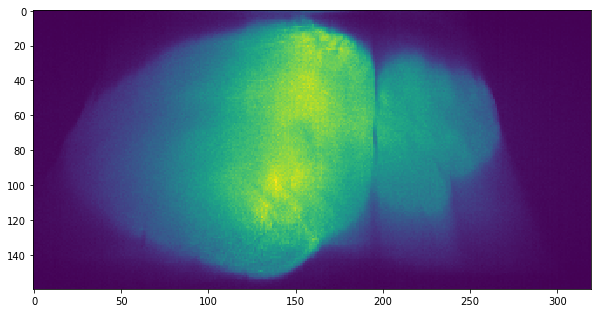

In [109]:
plt.imshow(sitk.GetArrayFromImage(sitk.Normalize(oriented_img))[50,:,:])

array([<matplotlib.image.AxesImage object at 0x7fa05ffc8e10>],
      dtype=object)

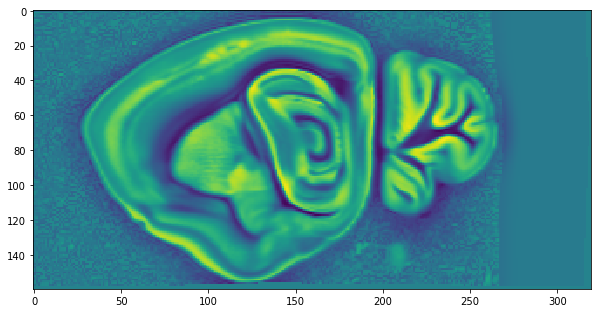

In [112]:
np.unique(plt.imshow(sitk.GetArrayFromImage(sitk.Normalize(lddmm_out_img))[50,:,:]))

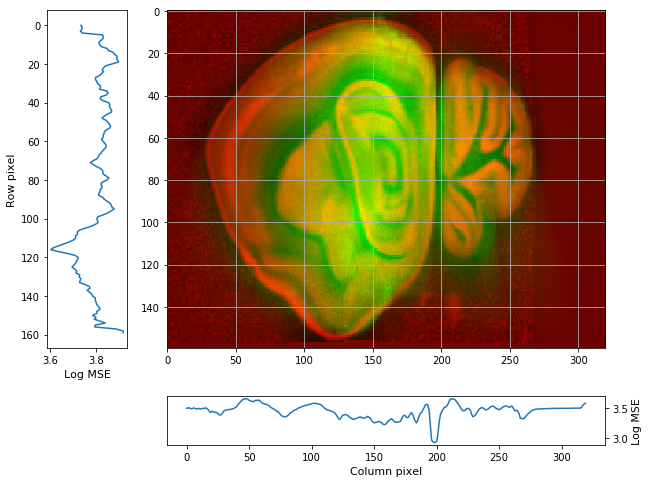

In [115]:
plot_mse(sitk.GetArrayFromImage(sitk.Normalize(lddmm_out_img))[50,:,:], sitk.GetArrayFromImage(sitk.Normalize(oriented_img))[50,:,:], color_blend=True)


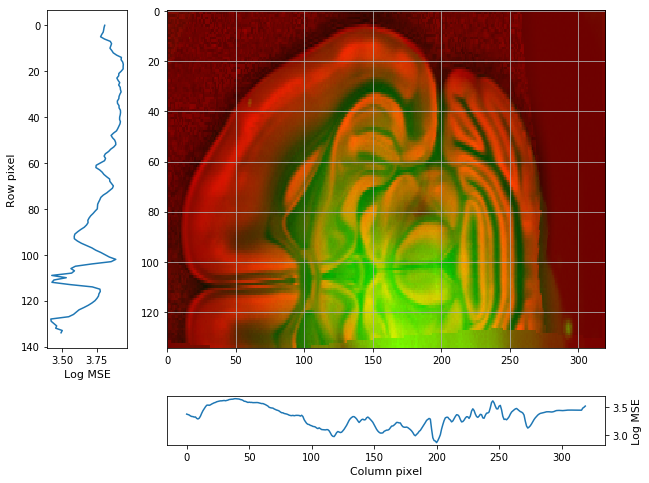

In [119]:
plot_mse(sitk.GetArrayFromImage(sitk.Normalize(lddmm_out_img))[:,50,:], sitk.GetArrayFromImage(sitk.Normalize(oriented_img))[:,50,:], color_blend=True)


In [120]:
sitk.WriteImage(sitk.Normalize(lddmm_out_img), './results.img')

In [121]:
%run -i ingest_tif_stack.py -collection=missing_data_registration \
-experiment=missing_insula_atenolol_registration_results \
-channel=half_no_missing_aug \
-img_stack=./results.img \
-fmt=img --dtype=uint16 --config=./intern.cfg --new_channel=True



True
uploading image to boss...
uint16
(0, [0, 320], [0, 160], [0, 16])
(0, [0, 320], [0, 160], [16, 32])
(0, [0, 320], [0, 160], [32, 48])
(0, [0, 320], [0, 160], [48, 64])
(0, [0, 320], [0, 160], [64, 80])
(0, [0, 320], [0, 160], [80, 96])
(0, [0, 320], [0, 160], [96, 112])
(0, [0, 320], [0, 160], [112, 128])
(0, [0, 320], [0, 160], [128, 135])
upload done! to see upload go to this link: http://ben-dev.neurodata.io:8001/ndviz_url/missing_data_registration/missing_insula_atenolol_registration_results/half_no_missing_aug/


In [111]:
import sys, random, ndreg
import numpy as np
import SimpleITK as sitk
import skimage
from ndreg import preprocessor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

    
def plot_mse(img1, img2, blend=0.2, color_blend=False):
    height, width = img1.shape
    overlap = np.zeros((height, width)) if not color_blend else np.zeros((height, width, 3))
    if not color_blend:
        for i in range(height):
            for j in range(width):
                grey = img1[i,j]*blend + img2[i,j]*blend
                overlap[i,j] = grey
    else:
        img1 = img1 + abs(np.amin(img1))
        img2 = img2 + abs(np.amin(img2))
        img1_max = np.amax(img1)
        img2_max = np.amax(img2)
        for i in range(height):
            for j in range(width):
#                 overlap[i,j,:] = (int(img1[i,j]/img1_max * 255), int(img2[i,j]/img2_max * 255), 0)
                overlap[i,j,:] = (img1[i,j]/img1_max, img2[i,j]/img2_max, 0)

    x_errors = []
    for j in range(width):
        error = np.sqrt(np.sum(np.square(img1[:,j] - img2[:,j])))
        x_errors.append(error)
    x_errors = np.log(np.array(x_errors))

    y_errors = []
    for i in range(height):
        error = np.sqrt(np.sum(np.square(img1[i,:] - img2[i,:])))
        y_errors.append(error)
    y_errors = np.log(np.array(y_errors))

    gs = gridspec.GridSpec(5, 5, wspace=0.5, hspace=1)

    ax1 = plt.subplot(gs[:4, 0])
    ax2 = plt.subplot(gs[:4, 1:])
    ax3 = plt.subplot(gs[4, 1:])

    ax1.plot(y_errors, range(height))
    ax1.invert_yaxis()
    ax1.set_xlabel('Log MSE',fontsize=11)
    ax1.set_ylabel('Row pixel', fontsize=11)

    ax3.plot(range(width), x_errors)
    ax3.set_xlabel('Column pixel',fontsize=11)
    ax3.set_ylabel('Log MSE', fontsize=11)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()


    ax2.imshow(overlap, aspect='auto')
    ax2.grid(True)